## Exp3 analysis of MS1 IT influence on quantification and identification 
**DIA-NN output**

In [1]:
#Importing packages 
import pandas as pd 
import numpy as np
import os 
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import mstats
import dask.dataframe as dd
sns.set_style("ticks")

myColors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

/Users/valdemaras/Programs/miniconda/miniconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#Data 
df = pd.read_csv("data/Exp2/MS1_evaluation_peptides.tsv",sep = "\t", decimal = ",") 
#Extracting the required information from the file name
df['Load'] =  df.iloc[:,0].str.extract(r'QC_(.*?)_')[0].values
df['IT'] =  df.iloc[:,0].str.extract(r'240k_(.*?)_40')[0].values
df['Replicate'] =  df.iloc[:,0].str.extract(r'pg_(.*)')[0].values
df = df.replace(0, np.nan)


In [3]:
df

,R.FileName,PG.ProteinGroups,PG.Quantity,PEP.GroupingKey,PEP.MS1Quantity,PEP.MS2Quantity,PEP.UsedForProteinGroupQuantity,EG.PrecursorId,EG.Qvalue,EG.DatapointsPerPeak (MS1),EG.DatapointsPerPeak,EG.FWHM,EG.MeanApexRT,EG.PeakWidth,EG.SignalToNoise,EG.TotalQuantity (Settings),EG.Noise,Load,IT,Replicate
0,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,A0A0B4J2D5;P0DPI2,3219.542969,_NLSTFAVDGK_,4613.901367,412.408539,True,_NLSTFAVDGK_.2,9.650925e-08,8.0,5.0,0.059711,10.288561,0.098907,18.334887,4613.901367,637.760620,1000pg,100ms,1
1,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,A0A0B4J2D5;P0DPI2,3219.542969,_PIGLC[Carbamidomethyl (C)]C[Carbamidomethyl (...,2955.940918,116.727318,True,_PIGLC[Carbamidomethyl (C)]C[Carbamidomethyl (...,2.975958e-09,9.0,4.0,0.044531,16.011360,0.077833,9.754626,2955.940918,522.656189,1000pg,100ms,1
2,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,A0A0B4J2D5;P0DPI2,3219.542969,_WPYAGTAEAIK_,1960.099609,84.036179,True,_WPYAGTAEAIK_.2,1.032969e-06,8.0,3.0,0.070037,12.571031,0.094385,18.468681,1960.099609,106.393608,1000pg,100ms,1
3,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,A0A0B4J2D5;P0DPI2,3219.542969,_GVEVTVGHEQEEGGK_,1018.705933,30.463642,True,_GVEVTVGHEQEEGGK_.3,1.751807e-05,4.0,1.0,0.084730,4.456933,0.044596,6.652745,1018.705933,108.289070,1000pg,100ms,1
4,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,A0A0B4J2D5;P0DPI2,3219.542969,_EVVEAHVDQK_,949.406433,69.104828,True,_EVVEAHVDQK_.2,6.108142e-16,6.0,4.0,0.049073,3.160025,0.075494,29.438965,949.406433,73.898781,1000pg,100ms,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696608,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,Q9Y6Y8,781.545593,_IDENYSLPTC[Carbamidomethyl (C)]K_,528.971191,33.638721,True,_IDENYSLPTC[Carbamidomethyl (C)]K_.2,6.441869e-05,4.0,2.0,0.051719,8.712810,0.047909,13.225069,528.971191,66.366966,750pg,200ms,3
1696609,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,Q9Y6Y8,781.545593,_LEPMIVPDLDLK_,63.288364,32.372223,True,_LEPMIVPDLDLK_.2,3.150695e-06,6.0,3.0,0.026906,16.140112,0.071257,8.015856,63.288364,111.666176,750pg,200ms,3
1696610,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,Q9Y6Y8,781.545593,_AAYWEEEPAEVRR_,72.744278,5.391174,True,_AAYWEEEPAEVRR_.3,1.933832e-04,4.0,1.0,0.028888,9.202812,0.046623,4.214966,72.744278,164.212463,750pg,200ms,3
1696611,20240502_OM_VP_Vanquish_uPAC_trapElute_wishDIA...,Q9Y6Y8,781.545593,_SAWQTLNEFAR_,194.967590,78.122856,True,_SAWQTLNEFAR_.2,1.966810e-03,4.0,1.0,0.027628,15.208563,0.039721,8.691346,194.967590,190.036758,750pg,200ms,3


#### Evaluating CVs

In [4]:
#Calculate the CVs for each condition

cv_ms1 = df.groupby(['Load','IT', 'PEP.GroupingKey'])['PEP.MS1Quantity'].apply(lambda x: np.std(x)/np.mean(x)).reset_index()
cv_ms2 = df.groupby(['Load','IT', 'PEP.GroupingKey'])['PEP.MS2Quantity'].apply(lambda x: np.std(x)/np.mean(x)).reset_index()
cv_ms1

,Load,IT,PEP.GroupingKey,PEP.MS1Quantity
0,1000pg,100ms,_AAAAAAAAAPAAAATAPTTAATTAATAAQ_,0.536613
1,1000pg,100ms,_AAAAAAAAAVSR_,0.133022
2,1000pg,100ms,_AAAAAAALQAK_,0.009578
3,1000pg,100ms,_AAAAADLANR_,0.030847
4,1000pg,100ms,_AAAALMQDR_,0.232013
...,...,...,...,...
591894,750pg,200ms,_[Acetyl (Protein N-term)]TTNAGPLHPYWPQHLR_,0.038754
591895,750pg,200ms,_[Acetyl (Protein N-term)]VDMMDLPR_,0.295476
591896,750pg,200ms,_[Acetyl (Protein N-term)]VDREQLVQK_,0.032652
591897,750pg,200ms,_[Acetyl (Protein N-term)]VEADRPGK_,0.085291


/Users/valdemaras/Programs/miniconda/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


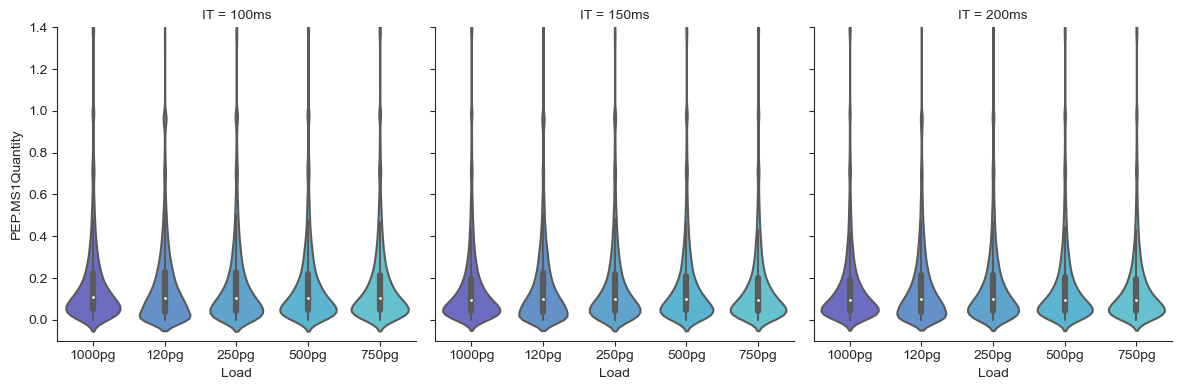

In [5]:
sns.catplot(
    data=cv_ms1, x="Load", y="PEP.MS1Quantity", col="IT", kind="violin", height=4,  
    col_order = ['100ms', '150ms', '200ms'], palette = myColors[2:], sharex=False).set(ylim=(-0.1, 1.4))

In [6]:

mean_ms1 = df.groupby(['Load','IT','PEP.GroupingKey'])['PEP.MS1Quantity'].apply(lambda x: np.log2(np.mean(x))).reset_index()
mean_ms2 = df.groupby(['Load','IT','PEP.GroupingKey'])['PEP.MS2Quantity'].apply(lambda x: np.log2(np.mean(x))).reset_index()

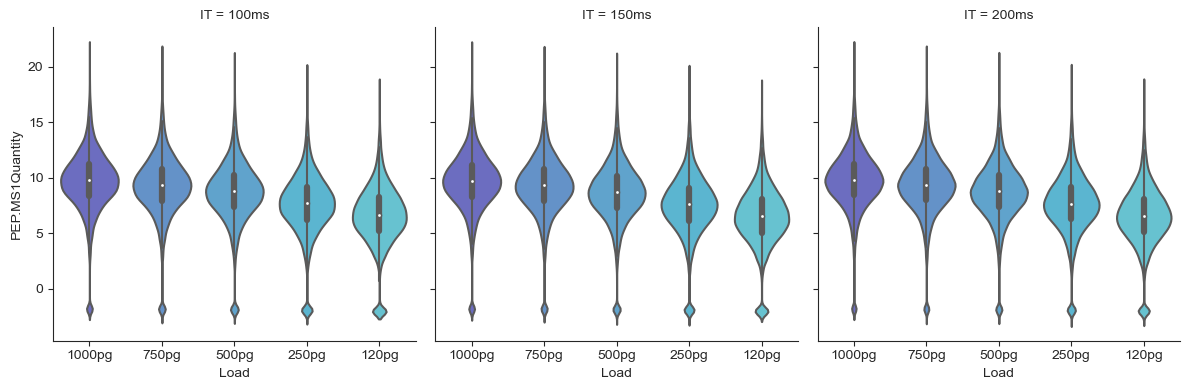

In [7]:
sns.catplot(
    data=mean_ms1, x="Load", y="PEP.MS1Quantity", col="IT", kind="violin", height=4,  
    col_order = ['100ms', '150ms', '200ms'], order=['1000pg', '750pg', '500pg', '250pg', '120pg'], palette = myColors[2:], sharex=False)#.set(ylim=(-0.1, 1.4))

In [8]:
mean_ms1 = df.groupby(['Load','IT','PEP.GroupingKey'])['PEP.MS1Quantity'].apply(lambda x: np.log2(np.mean(x))).reset_index()

<AxesSubplot:xlabel='er_120', ylabel='Count'>

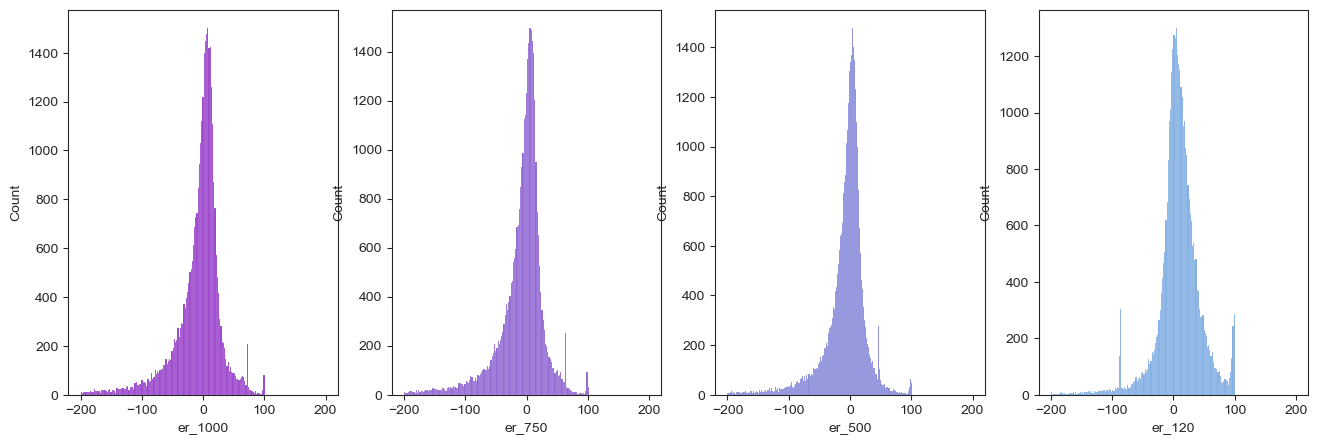

In [9]:
quant_100ms = df.loc[df.IT == '100ms',].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()


quant_100ms['er_1000'] = (1000/250 - (quant_100ms['1000pg']/quant_100ms['250pg']))/(1000/250) * 100
quant_100ms['er_750'] = (750/250 - (quant_100ms['750pg']/quant_100ms['250pg']))/(750/250) * 100
quant_100ms['er_500'] = (500/250 - (quant_100ms['500pg']/quant_100ms['250pg']))/(500/250) * 100
quant_100ms['er_120'] = (125/250 - (quant_100ms['120pg']/quant_100ms['250pg']))/(125/250) * 100


fig, axes = plt.subplots(1,4, figsize = (16,5)) 
sns.histplot(data = quant_100ms, x = 'er_1000', color = myColors[0], ax =axes[0], binrange=(-200,200))
sns.histplot(data = quant_100ms, x = 'er_750', color = myColors[1], ax=axes[1], binrange=(-200,200))
sns.histplot(data = quant_100ms, x = 'er_500', color = myColors[2], ax=axes[2], binrange=(-200,200))
sns.histplot(data = quant_100ms, x = 'er_120', color = myColors[3], ax=axes[3], binrange=(-200,200))

<AxesSubplot:xlabel='er_120', ylabel='Count'>

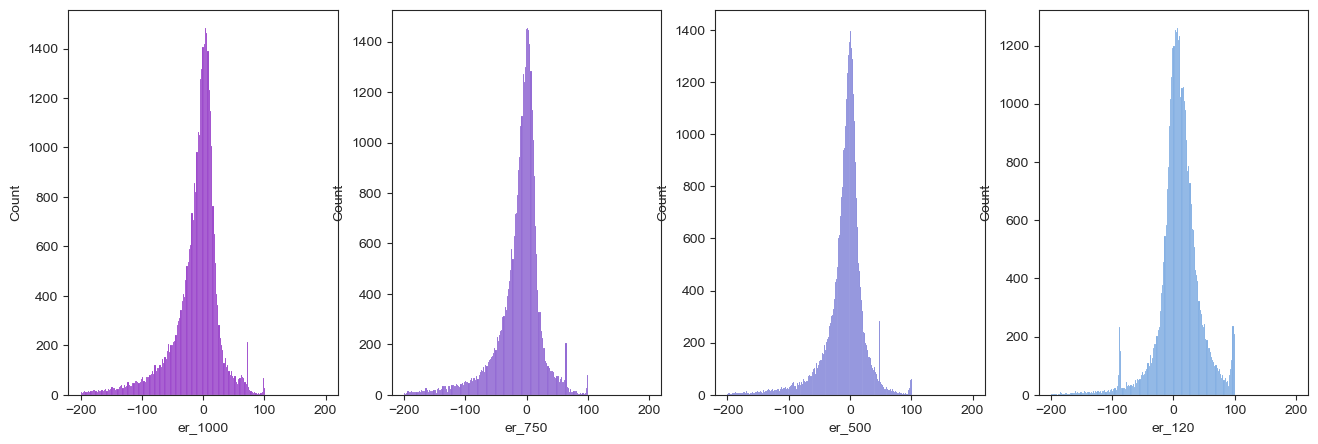

In [10]:
quant_150ms = df.loc[df.IT == '150ms',].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()


quant_150ms['er_1000'] = (1000/250 - (quant_150ms['1000pg']/quant_150ms['250pg']))/(1000/250) * 100
quant_150ms['er_750'] = (750/250 - (quant_150ms['750pg']/quant_150ms['250pg']))/(750/250) * 100
quant_150ms['er_500'] = (500/250 - (quant_150ms['500pg']/quant_150ms['250pg']))/(500/250) * 100
quant_150ms['er_120'] = (125/250 - (quant_150ms['120pg']/quant_150ms['250pg']))/(125/250) * 100


fig, axes = plt.subplots(1,4, figsize = (16,5)) 
sns.histplot(data = quant_150ms, x = 'er_1000', color = myColors[0], ax =axes[0], binrange=(-200,200))
sns.histplot(data = quant_150ms, x = 'er_750', color = myColors[1], ax=axes[1], binrange=(-200,200))
sns.histplot(data = quant_150ms, x = 'er_500', color = myColors[2], ax=axes[2], binrange=(-200,200))
sns.histplot(data = quant_150ms, x = 'er_120', color = myColors[3], ax=axes[3], binrange=(-200,200))

<AxesSubplot:xlabel='er_120', ylabel='Count'>

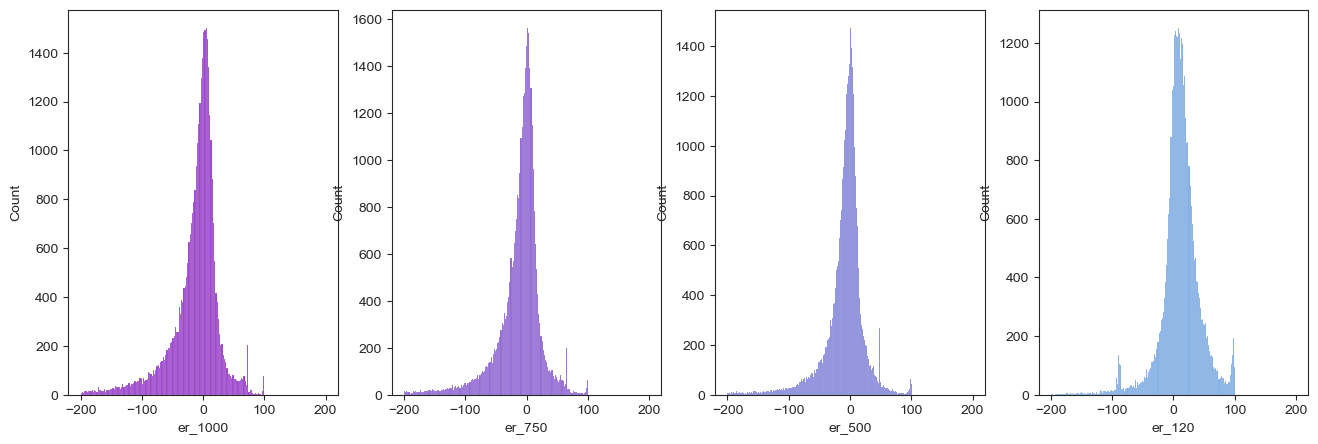

In [11]:
quant_200ms = df.loc[df.IT == '200ms',].pivot_table(values="PEP.MS1Quantity", index="PEP.GroupingKey", columns="Load", aggfunc="mean").reset_index().dropna()


quant_200ms['er_1000'] = (1000/250 - (quant_200ms['1000pg']/quant_200ms['250pg']))/(1000/250) * 100
quant_200ms['er_750'] = (750/250 - (quant_200ms['750pg']/quant_200ms['250pg']))/(750/250) * 100
quant_200ms['er_500'] = (500/250 - (quant_200ms['500pg']/quant_200ms['250pg']))/(500/250) * 100
quant_200ms['er_120'] = (125/250 - (quant_200ms['120pg']/quant_200ms['250pg']))/(125/250) * 100


fig, axes = plt.subplots(1,4, figsize = (16,5)) 
sns.histplot(data = quant_200ms, x = 'er_1000', color = myColors[0], ax =axes[0], binrange=(-200,200))
sns.histplot(data = quant_200ms, x = 'er_750', color = myColors[1], ax=axes[1], binrange=(-200,200))
sns.histplot(data = quant_200ms, x = 'er_500', color = myColors[2], ax=axes[2], binrange=(-200,200))
sns.histplot(data = quant_200ms, x = 'er_120', color = myColors[3], ax=axes[3], binrange=(-200,200))

In [12]:
#Some really bad but simple code to calculate the difference in error rates between the two ITs
ms100_1000 = pd.cut(quant_100ms['er_1000'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms100_1000['er_1000'] = ms100_1000['er_1000']/ms100_1000['er_1000'].sum() * 100
ms200_1000 = pd.cut(quant_200ms['er_1000'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms200_1000['er_1000'] = ms200_1000['er_1000']/ms200_1000['er_1000'].sum() * 100

ms100_750 = pd.cut(quant_100ms['er_750'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms100_750['er_750'] = ms100_750['er_750']/ms100_750['er_750'].sum() * 100
ms200_750 = pd.cut(quant_200ms['er_750'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms200_750['er_750'] = ms200_750['er_750']/ms200_750['er_750'].sum() * 100

ms100_500 = pd.cut(quant_100ms['er_500'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms100_500['er_500'] = ms100_500['er_500']/ms100_500['er_500'].sum() * 100
ms200_500 = pd.cut(quant_200ms['er_500'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms200_500['er_500'] = ms200_500['er_500']/ms200_500['er_500'].sum() * 100

ms100_120 = pd.cut(quant_100ms['er_120'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms100_120['er_120'] = ms100_120['er_120']/ms100_120['er_120'].sum() * 100
ms200_120 = pd.cut(quant_200ms['er_120'], bins= np.arange(-200,200,5)).value_counts().reset_index();ms200_120['er_120'] = ms200_120['er_120']/ms200_120['er_120'].sum() * 100

e1000 = pd.merge(ms100_1000, ms200_1000, on = 'index');e1000['diff_1000'] = e1000['er_1000_x'] - e1000['er_1000_y']
e750 = pd.merge(ms100_750, ms200_750, on = 'index');e750['diff_750'] = e750['er_750_x'] - e750['er_750_y']
e500 = pd.merge(ms100_500, ms200_500, on = 'index');e500['diff_500'] = e500['er_500_x'] - e500['er_500_y']
e120 = pd.merge(ms100_120, ms200_120, on = 'index');e120['diff_120'] = e120['er_120_x'] - e120['er_120_y']

er_list = [e750, e500, e120]

er = e1000

for i in er_list:
    er = er.merge(i, on = 'index')



er = pd.melt(er.loc[:,er.columns.str.contains('diff|index')], id_vars = 'index')
er['first'] = er['index'].astype(str).str.extract(r'\((.*),')[0].astype(int)
er['second'] = er['index'].astype(str).str.extract(r',(.*)]')[0].astype(int)
er['center'] = (er['first'] + er['second'])/2

er = er.drop('index', axis = 1)

In [13]:
#er.to_csv("data/Exp2/error_difference.tsv", sep = "\t", index = False)
#quant.to_csv("data/Exp2/error.tsv", sep = "\t", index = False)